In [94]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ftHhmXmYoorcuab83x0O")
project = rf.workspace("desmondwong").project("court-detection-bxo2j-lppkt")
version = project.version(2)
dataset = version.download("coco")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
loading Roboflow workspace...
loading Roboflow project...


# Model Training

In [95]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
!nvidia-smi

Fri Jul 25 14:22:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              3W /   20W |    2409MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Create Torch Dataset

In [98]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)
        self.images = self.data["images"]

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        item = self.images[idx]
        img = cv2.imread(f"{self.img_dir}/{item['file_name']}")
        h, w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)

        # Find the annotation for this image
        ann = next(a for a in self.data["annotations"] if a["image_id"] == item["id"])
        kps = np.array(ann["keypoints"]).astype(np.float32)
        kps = kps[:36]  # 12 keypoints (x, y, v) each

        # Adjust x/y coordinates
        kps[0::3] *= 224.0 / w  # x
        kps[1::3] *= 224.0 / h  # y

        # Only keep x and y (drop visibility if needed)
        kps = np.stack([kps[0::3], kps[1::3]], axis=1).flatten()

        return img, kps

In [99]:
print(dataset.location)

c:\Desmond Wong\Education\Learning AI\Projects\pickleball_video_analysis\training\Court-Detection-2


In [100]:
import os

train_img_dir = os.path.join(dataset.location, "train")
train_ann_file = os.path.join(dataset.location, "train", "_annotations.coco.json")
val_img_dir = os.path.join(dataset.location, "valid")
val_ann_file = os.path.join(dataset.location, "valid", "_annotations.coco.json")

train_dataset = KeypointsDataset(train_img_dir, train_ann_file)
val_dataset = KeypointsDataset(val_img_dir, val_ann_file)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## Create & Train Model

In [101]:
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc =  torch.nn.Linear(model.fc.in_features, 12*2) # Replaces the last layer

In [102]:
model = model.to(device)

In [103]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [104]:
epochs=100
for epoch in range(epochs):
    for i, (imgs,kps) in enumerate(train_loader):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, iter {i}, loss: {loss.item()}")

Epoch 0, iter 0, loss: 14001.7958984375
Epoch 0, iter 10, loss: 14672.4404296875
Epoch 0, iter 20, loss: 15452.185546875
Epoch 0, iter 30, loss: 14845.6826171875
Epoch 0, iter 40, loss: 14922.115234375
Epoch 0, iter 50, loss: 13659.0703125
Epoch 1, iter 0, loss: 13727.0771484375
Epoch 1, iter 10, loss: 12205.068359375
Epoch 1, iter 20, loss: 10414.44921875
Epoch 1, iter 30, loss: 8179.74755859375
Epoch 1, iter 40, loss: 7618.1904296875
Epoch 1, iter 50, loss: 7321.09521484375
Epoch 2, iter 0, loss: 5752.85546875
Epoch 2, iter 10, loss: 5761.56640625
Epoch 2, iter 20, loss: 5328.18505859375
Epoch 2, iter 30, loss: 4604.91259765625
Epoch 2, iter 40, loss: 4096.7568359375
Epoch 2, iter 50, loss: 4117.88671875
Epoch 3, iter 0, loss: 3640.4755859375
Epoch 3, iter 10, loss: 3270.518310546875
Epoch 3, iter 20, loss: 3273.78271484375
Epoch 3, iter 30, loss: 2590.138427734375
Epoch 3, iter 40, loss: 2911.69482421875
Epoch 3, iter 50, loss: 2852.216796875
Epoch 4, iter 0, loss: 2141.824951171875

In [108]:
torch.save(model.state_dict(), "keypoints_model.pth")

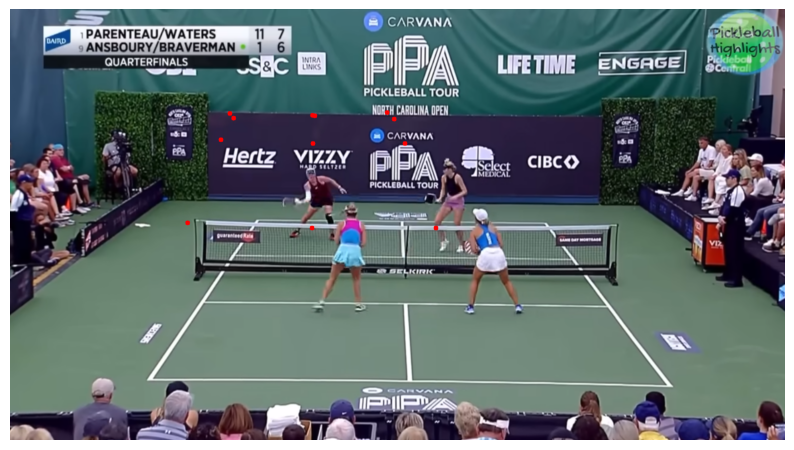

In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# --- 1. Load the model ---
model.load_state_dict(torch.load("../artifacts/models/keypoints_model.pth", map_location=device, weights_only=True))
model.to(device)
model.eval()


# --- 2. Load the original image ---
image_path = '../input_videos/test.png'

image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image from {image_path}")
    exit()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- 3. Preprocess and run model ---
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    keypoints = outputs.cpu().numpy().reshape(-1, 2)

# Scale keypoints back to original image size
h, w, _ = image.shape
keypoints[:, 0] *= w / 224.0
keypoints[:, 1] *= h / 224.0

# Draw keypoints on the image
for x, y in keypoints:
    cv2.circle(image, (int(x), int(y)), 5, (255, 0, 0), -1)

# --- 4. Display the image with keypoints ---
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [107]:
stop

NameError: name 'stop' is not defined

## Model trained on Roboflow

In [ ]:
from inference_sdk import InferenceHTTPClient
import os
from dotenv import load_dotenv

load_dotenv() # Load the .env file
api_key = os.getenv("ROBOFLOW_API_KEY")

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=api_key
)

image_path = '../input_videos/frames_00304_jpg.rf.1bfef6c4799a2e6fbb850802256667b3.jpg'

result = CLIENT.infer(inference_input=image_path, model_id="pickle-court-keypoints-nluo7-8nk97/4")
print(result)

{'inference_id': '272a12ff-e019-4b7f-ad82-2c2c704534ff', 'time': 0.016608938999979728, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 347.0, 'y': 308.0, 'width': 566.0, 'height': 464.0, 'confidence': 0.8661877512931824, 'class': 'court', 'class_id': 0, 'detection_id': '55859f26-d5f0-4b32-b4c4-a819c2695760', 'keypoints': [{'x': 273.0, 'y': 97.0, 'confidence': 0.9902419447898865, 'class_id': 0, 'class': '1'}, {'x': 315.0, 'y': 97.0, 'confidence': 0.9984369874000549, 'class_id': 1, 'class': '2'}, {'x': 364.0, 'y': 94.0, 'confidence': 0.9665079116821289, 'class_id': 2, 'class': '3'}, {'x': 370.0, 'y': 175.0, 'confidence': 0.995518147945404, 'class_id': 3, 'class': '4'}, {'x': 312.0, 'y': 180.0, 'confidence': 0.9998878240585327, 'class_id': 4, 'class': '5'}, {'x': 262.0, 'y': 179.0, 'confidence': 0.9985213875770569, 'class_id': 5, 'class': '6'}, {'x': 250.0, 'y': 243.0, 'confidence': 0.9911653399467468, 'class_id': 6, 'class': '7'}, {'x': 313.0, 'y': 247.0, 'confidence': 0.99

{'inference_id': 'add4413a-2a67-4966-9790-da85ddae5658', 'time': 0.016201587999603362, 'image': {'width': 640, 'height': 640}, 'predictions': [{'x': 347.0, 'y': 308.0, 'width': 566.0, 'height': 464.0, 'confidence': 0.8661877512931824, 'class': 'court', 'class_id': 0, 'detection_id': '3182d9a9-a6b6-437b-8317-57627b9c772d', 'keypoints': [{'x': 273.0, 'y': 97.0, 'confidence': 0.9902419447898865, 'class_id': 0, 'class': '1'}, {'x': 315.0, 'y': 97.0, 'confidence': 0.9984369874000549, 'class_id': 1, 'class': '2'}, {'x': 364.0, 'y': 94.0, 'confidence': 0.9665079116821289, 'class_id': 2, 'class': '3'}, {'x': 370.0, 'y': 175.0, 'confidence': 0.995518147945404, 'class_id': 3, 'class': '4'}, {'x': 312.0, 'y': 180.0, 'confidence': 0.9998878240585327, 'class_id': 4, 'class': '5'}, {'x': 262.0, 'y': 179.0, 'confidence': 0.9985213875770569, 'class_id': 5, 'class': '6'}, {'x': 250.0, 'y': 243.0, 'confidence': 0.9911653399467468, 'class_id': 6, 'class': '7'}, {'x': 313.0, 'y': 247.0, 'confidence': 0.99

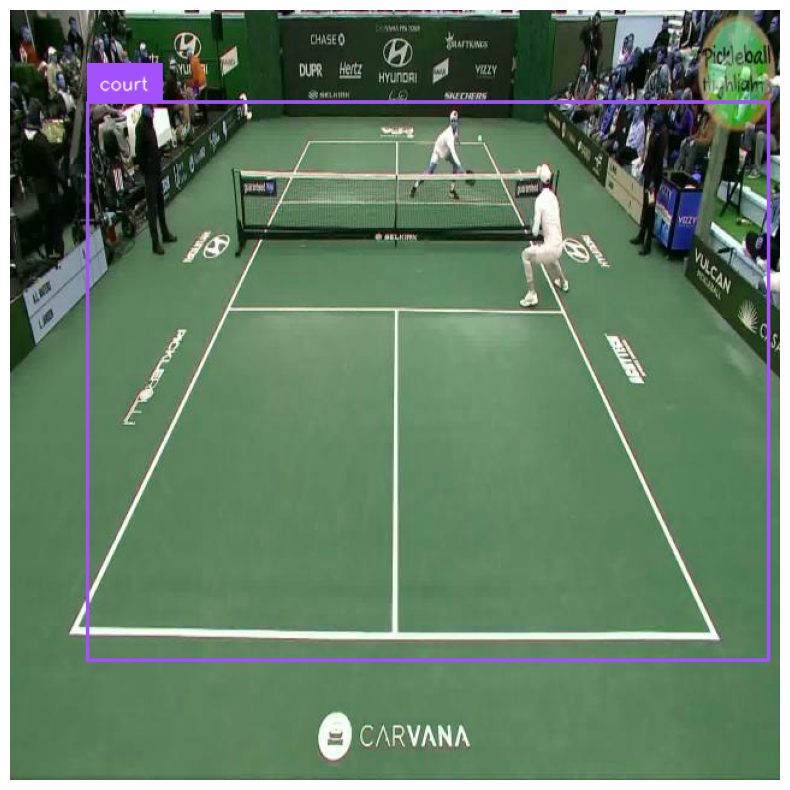

In [123]:
import cv2
import supervision as sv
from inference_sdk import InferenceHTTPClient
import numpy as np

from inference_sdk import InferenceHTTPClient
from dotenv import load_dotenv

# --- 1. Roboflow Inference Setup ---

load_dotenv() # Load the .env file
api_key = os.getenv("ROBOFLOW_API_KEY")

CLIENT = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key=api_key
)

result = CLIENT.infer(inference_input=image_path, model_id="pickle-court-keypoints-nluo7-8nk97/4")
print(result)

# # --- 2. Load the original image ---
image_path = '../input_videos/frames_00304_jpg.rf.1bfef6c4799a2e6fbb850802256667b3.jpg'

image = cv2.imread(image_path)

# Check if image was loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}")
    exit()

# Convert the image from BGR to RGB (OpenCV loads in BGR, but most display tools expect RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- 3. Process Roboflow result with Supervision ---
# Create a Supervision Detections object from the Roboflow result
detections = sv.Detections.from_inference(result)

# Optionally filter detections based on confidence if needed
detections = detections[detections.confidence > 0.15]

# Get the class names from the result
class_names = [p["class"] for p in result["predictions"]]

# --- 4. Annotate the image with bounding boxes and labels ---
# Create annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Annotate the image
annotated_image = bounding_box_annotator.annotate(
    scene=image.copy(), # Make a copy to avoid modifying the original image
    detections=detections
)

# Add labels
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=class_names # Pass the extracted class names for display
)

# --- 5. Display the annotated image ---
sv.plot_image(annotated_image, size=(10, 10))

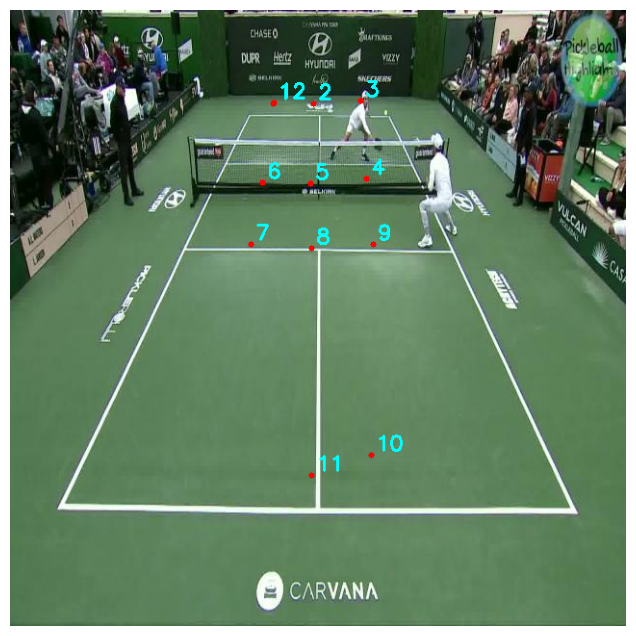

In [126]:
# Get the first prediction (assuming only one court detected)
prediction = result['predictions'][0]

# Draw keypoints
for kp in prediction['keypoints']:
    x, y = int(kp['x']), int(kp['y'])
    # Draw a smaller circle at each keypoint
    cv2.circle(image, (x, y), 3, (255, 0, 0), -1)  # Red color, filled (BGR: 255,0,0)

    # Optionally, draw the keypoint class name
    cv2.putText(image, kp['class'], (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

# Display the image with keypoints
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()